# Example Notebook for Number Squeezing

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import strawberryfields as sf
from strawberryfields import ops

from scipy.optimize import curve_fit

import pandas as pd

%config InlineBackend.figure_format='retina'

We first want to look at what we are trying to reproduce with pennylane. The graph below is from a [paper](https://arxiv.org/abs/1507.03782) by Helmut Strobel. In this paper the collective spin of a Bose-Einstein-Condensate is used to observe nonlinearity in spin squeezing. This notebook aims to simulate the experimental results using pennylane.

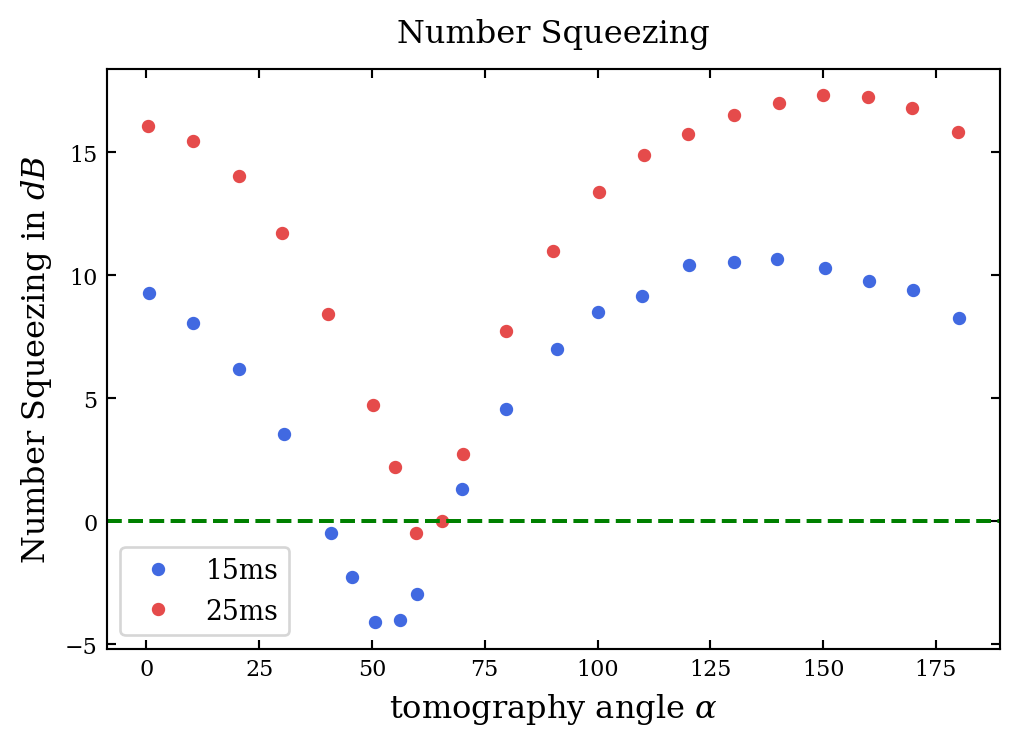

In [2]:
data_strobel_15 = pd.read_csv('Data/Strobel_Data_15ms.csv', names = ['dB', "alpha"])
data_strobel_25 = pd.read_csv('Data/Strobel_Data_25ms.csv', names = ['dB', "alpha"])

plt.figure(dpi=96)
plt.title("Number Squeezing")
plt.plot(data_strobel_15.dB, data_strobel_15.alpha, 'o', label="15ms", markersize=4)
plt.plot(data_strobel_25.dB, data_strobel_25.alpha, 'o', label="25ms", markersize=4)
plt.axhline(y=0, color='g', linestyle='--')
plt.ylabel(r'Number Squeezing in $dB$')
plt.xlabel(r'tomography angle $\alpha$')
_ = plt.legend()

This number squeezing is achieved by performing the following Bloch-sphere rotations. 

We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 

#### First step
As a first step the vector is rotated onto the equator.
<center><img width="200" height="300" src="Bloch_spheres/1.png"><\center>

#### Second step
Then the state is being squeezed, such that it starts to wrap around the Bloch-sphere.
    
<center><img width="200" height="300" src="Bloch_spheres/2.png"><\center>

#### Third step   
In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.
    
<center>
<img width="300" height="400" src="Bloch_spheres/alpha.png">
<\center>

At first we want to see how we can implement the $\hat{L}_z^2$ operation (squeezing in step 2) in the pennylane language. Just like in the example of the paper of Cindy Regal we will start off by modeling the number of $|\uparrow\rangle$ states and $|\downarrow\rangle$ states with Fock states. This is called "dual rail encoding". <font color=purple> This is also exactly what we do physically. It is also called Schwinger representation of a spin. All different names for the same thing ...</font>

We can write the $\hat{L}_z^2$ operator in exponential from with Kerr $K_i(\kappa)=e^{i\kappa n_i^2}$ and Cross-Kerr gates $KC_{i, j}(\kappa)=e^{i\kappa n_in_j}$. $\hat{L}_z^2 = (n_1 - n_2)^2 = n_1^2 - 2n_1n_2 + n_2^2$.

In [3]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_test(kappa, var=False):
    #initialization
    qml.FockState(5, wires=0)
    qml.FockState(0, wires=1)
    #L_z^2
    qml.Kerr(kappa, wires=0)
    qml.Kerr(kappa, wires=1)
    qml.CrossKerr(-kappa*2, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]

In [4]:
Kerr_test(1)
print(Kerr_test.draw())

 0: ──|5⟩──Kerr(1)──╭CrossKerr(-2)──┤ ⟨n⟩ 
 1: ──|0⟩──Kerr(1)──╰CrossKerr(-2)──┤ ⟨n⟩ 



# Ramsey

Let us implement a simple example, where the $L_z^2$ is sandwiched in between two symmetric beamsplitters:

- A first beamsplitter around $X$ moves the spin onto the equator centered around $Y$. This is done by using the parameters $\phi=\frac{\pi}{2}$, $\theta=\frac{\pi}{4}$ for the beamsplitter
- The non-linearity squeezes the state.
- The second beam splitter around $Y$ transforms fluctuations in the $XY$ component into fluctuations on $Z$.  This is done by using the parameters $\phi=0$, $\theta=\frac{\pi}{4}$ for the beamsplitter

In [5]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_Ramsey(kappa, alpha=np.pi/4, var=False, fock_number=5):
    '''
    Sandwich the Lz^2 in between two Beamsplitters. What we change is the time that the non-linearity is applied.
    '''
    #initialization
    qml.FockState(fock_number, wires=0)
    qml.FockState(0, wires=1)
    
    #Step 1
    qml.Beamsplitter(np.pi/4, 0, wires=[0, 1])
    
    #Step 2
    qml.Kerr(kappa, wires=0)
    qml.Kerr(kappa, wires=1)
    qml.CrossKerr(-kappa*2, wires=[0, 1])
    
    #Step 3
    qml.Beamsplitter(alpha, np.pi/2, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    


In [6]:
Kerr_Ramsey(1)
print(Kerr_Ramsey.draw())

 0: ──|5⟩──╭BS(0.785, 0)──Kerr(1)──╭CrossKerr(-2)──╭BS(0.785, 1.571)──┤ ⟨n⟩ 
 1: ──|0⟩──╰BS(0.785, 0)──Kerr(1)──╰CrossKerr(-2)──╰BS(0.785, 1.571)──┤ ⟨n⟩ 



We can now start testing the effect of the Kerr gates. For this we plot the variance of the two number operators over the tomography angle $\alpha$. 

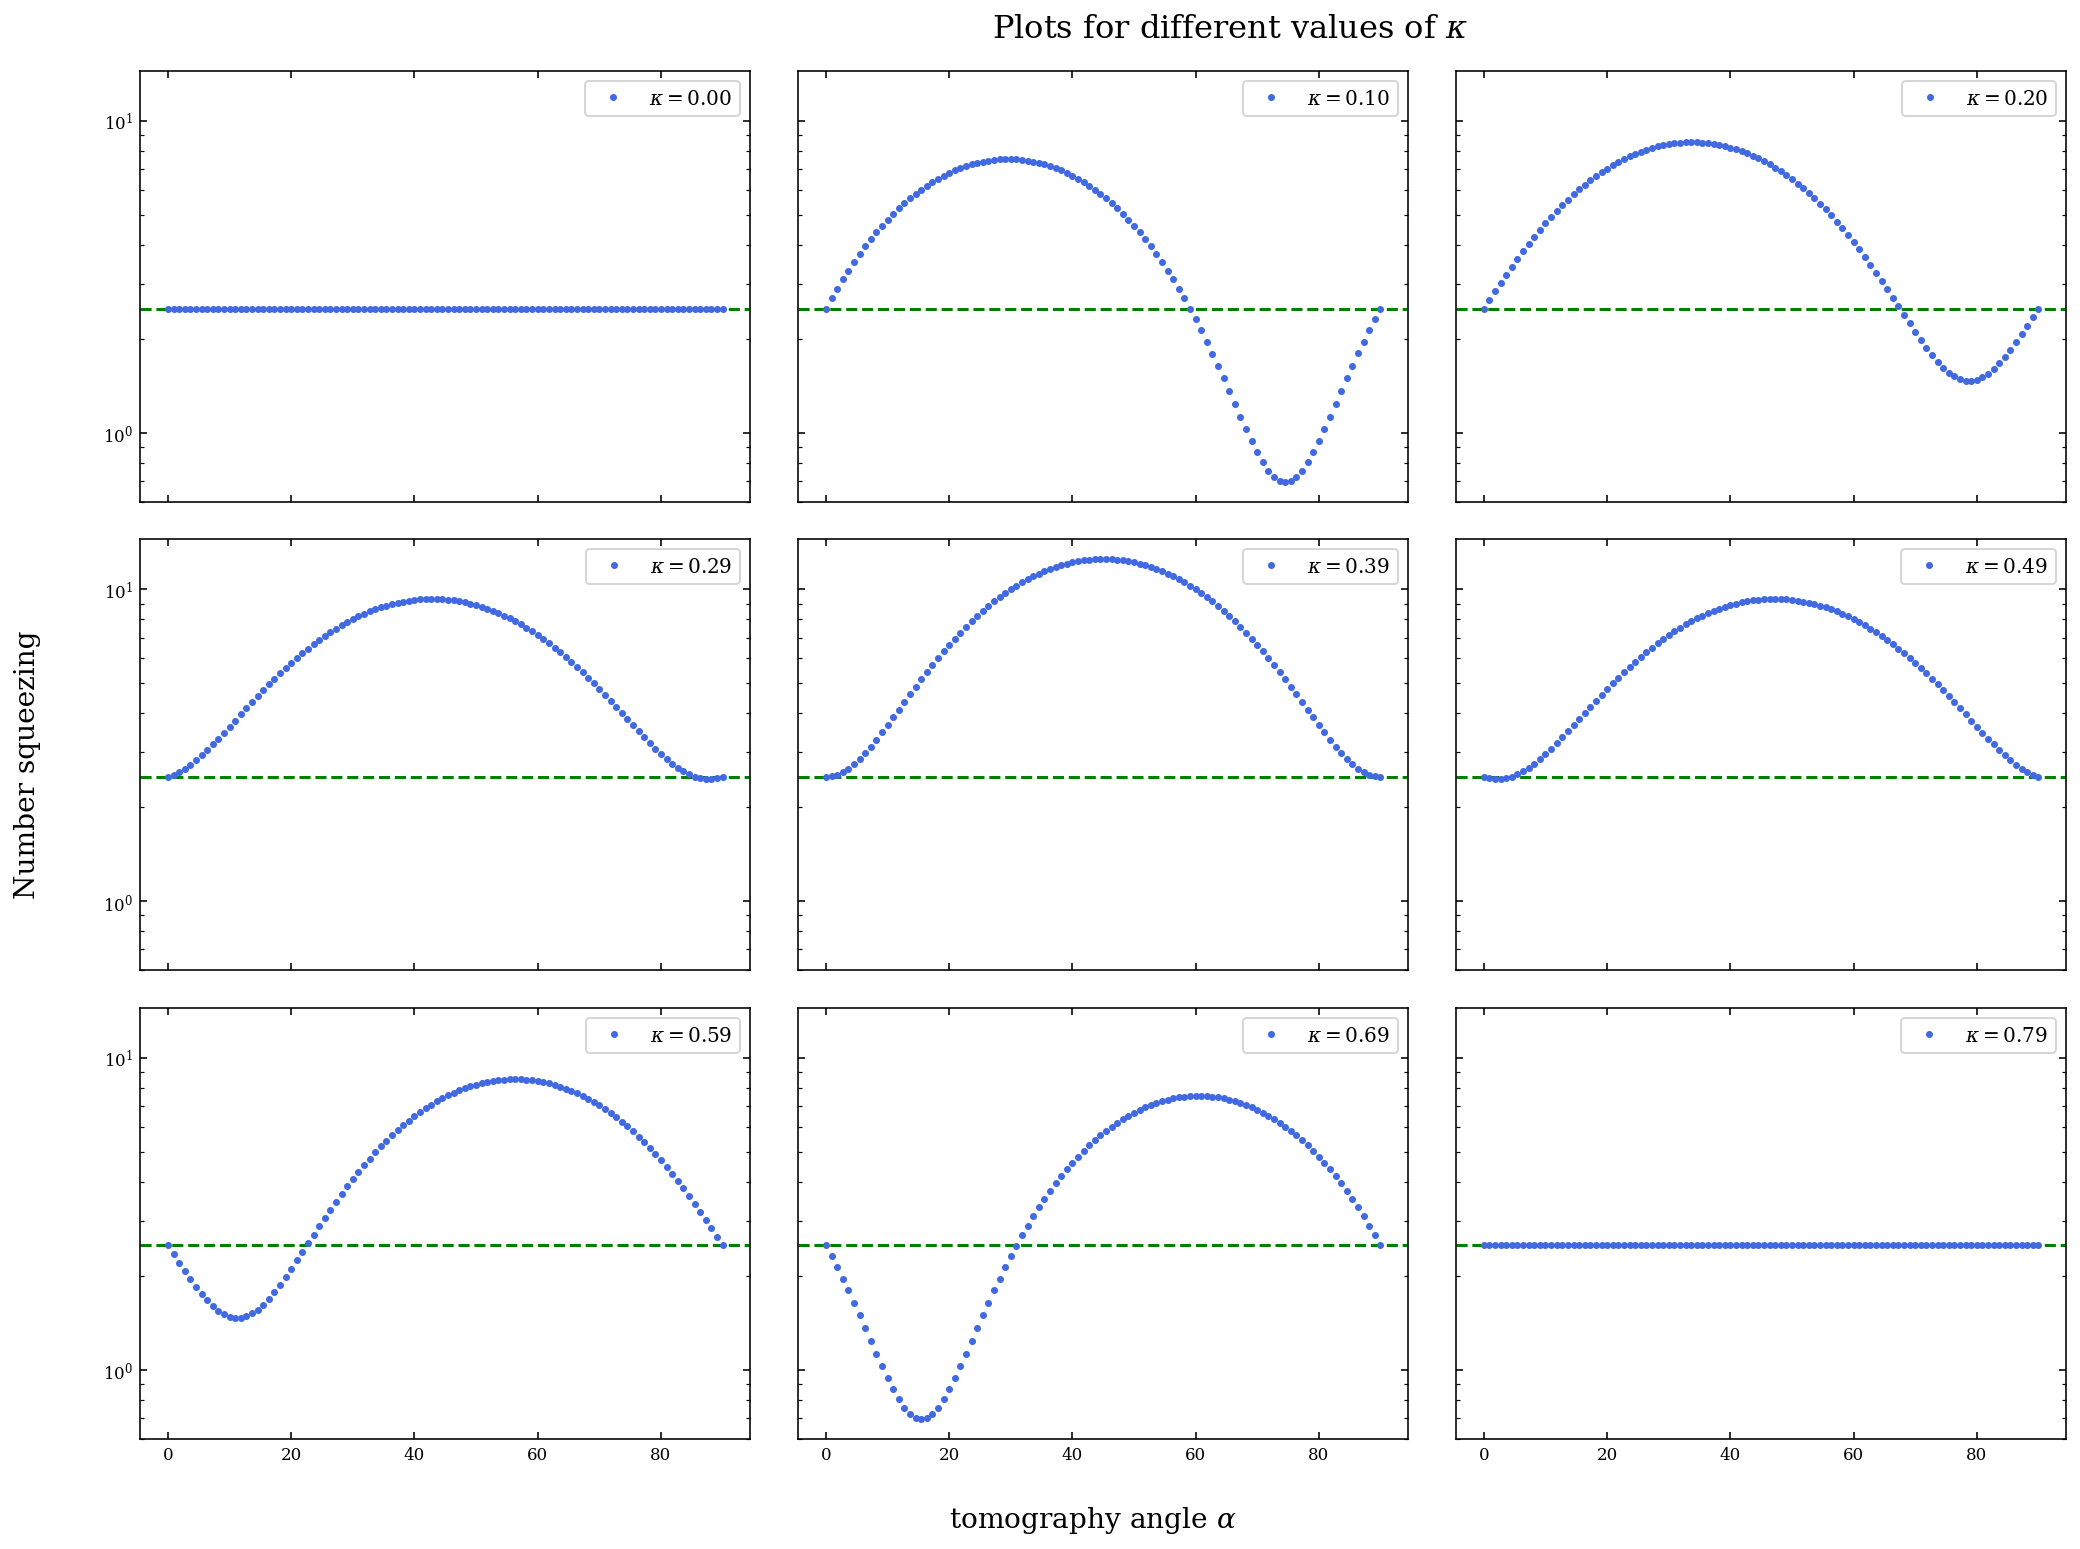

In [7]:
num_rows = 3
num_cols = 3

Nalphas = 100
Nkappas = num_rows*num_cols

kappas = np.linspace(0, np.pi/4, Nkappas)
alphas = np.linspace(0, np.pi/2, Nalphas);
fig, axs = plt.subplots(num_rows, num_cols, figsize=(14,10), sharey="all", sharex="all")
fig.tight_layout()

fig.text(0.5, -0.03, r'tomography angle $\alpha$', ha='center', fontsize=14)
fig.text(-0.035, 0.5, 'Number squeezing', va='center', rotation='vertical', fontsize=14)
fig.text(0.45, 1.01, r'Plots for different values of $\kappa$', va='center', fontsize=16)


for i in range(num_rows):
    for j in range(num_cols):
        index = i*num_cols+j


        varsUp = np.zeros(Nalphas);
        varsDown = np.zeros(Nalphas);

        for ii in np.arange(Nalphas):
            varsUp[ii], varsDown[ii] = Kerr_Ramsey(kappas[index], alpha=alphas[ii], var=True,)

        Lz_var = varsUp + varsDown
        axs[i, j].axhline(y=2.5, color='g', linestyle='--')

        axs[i, j].plot(np.degrees(alphas), Lz_var, ".", label=f"$\kappa=${kappas[index]:.2f}", markersize=5)
        axs[i, j].legend()
        axs[i, j].set_yscale("log")

We can see that the variance has a cyclic behavior. For some values of $\kappa$ the number squeezing drops to a point below the coherent state level (dashed, green line). Comparing the plots where this happens to the data from the [paper](https://arxiv.org/abs/1507.03782) of Helmut Strobel one can see many similarities. The only difference is, that the experimental data does not start from a coherent state for $\alpha=0$. This is due to the fact that in the paper there is an additional term in the Hamiltonian. This term scales with $\Lambda$, see [2.1.8](http://archiv.ub.uni-heidelberg.de/volltextserver/20251/1/HelmutStrobel_PHD.pdf).

In [8]:
def number_squeezing_factor_to_db(var_CSS, var):
    return 10*np.log10(var/var_CSS)

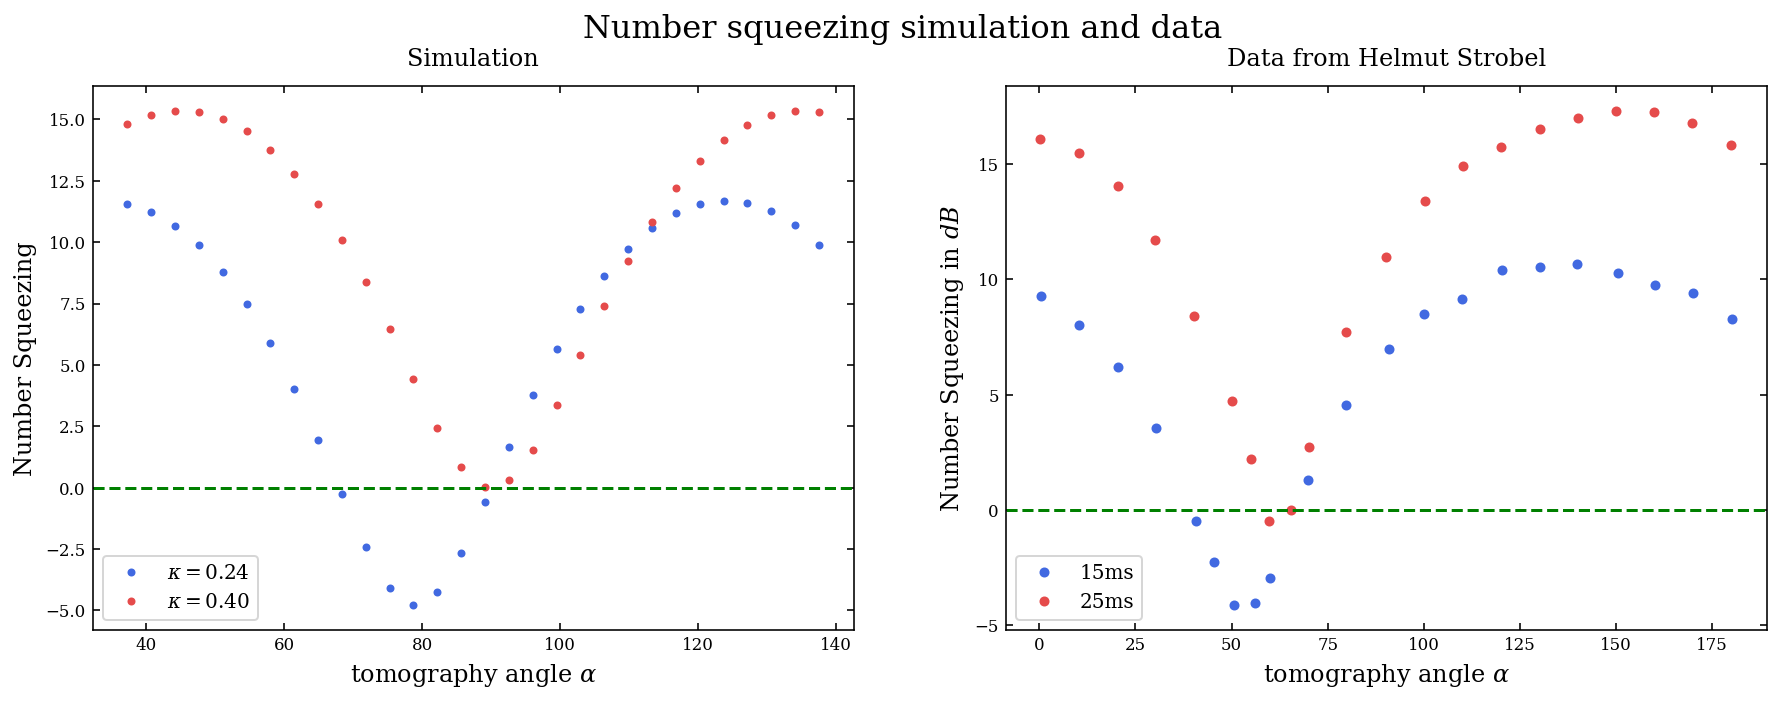

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
f.suptitle("Number squeezing simulation and data", fontsize=16)

Nalphas = 30
Nkappas = 10
kappas = np.linspace(0, np.pi/8, Nkappas)
alphas = np.linspace(0.65, 2.4, Nalphas);
meansUp = np.zeros(Nalphas);
meansDown = np.zeros(Nalphas);

varsUp = np.zeros(Nalphas);
varsDown = np.zeros(Nalphas);

scaling_factor = 2.2


for ii in np.arange(Nalphas):
    varsUp[ii], varsDown[ii] = Kerr_Ramsey(0.2, alpha=alphas[ii], var=True)

Lz_var = varsUp + varsDown

number_squeezing = number_squeezing_factor_to_db(2.5, Lz_var)

ax1.plot(np.degrees(alphas), number_squeezing*scaling_factor, ".", label=f"$\kappa=${0.24:.2f}")



for ii in np.arange(Nalphas):
    varsUp[ii], varsDown[ii] = Kerr_Ramsey(0.4, alpha=alphas[ii], var=True)


Lz_var = varsUp + varsDown

number_squeezing = number_squeezing_factor_to_db(2.5, Lz_var)

ax1.plot(np.degrees(alphas), number_squeezing*scaling_factor, ".", label=f"$\kappa=${0.4:.2f}", markersize=6)


ax1.legend()
ax1.set_title("Simulation")
#ax1.set_yscale("log")
ax1.axhline(y=0, color='g', linestyle='--')
ax1.set_ylabel('Number Squeezing')
ax1.set_xlabel(r'tomography angle $\alpha$')




ax2.set_title("Data from Helmut Strobel")
ax2.plot(data_strobel_15.dB, data_strobel_15.alpha, 'o', label="15ms", markersize=4)
ax2.plot(data_strobel_25.dB, data_strobel_25.alpha, 'o', label="25ms", markersize=4)
ax2.axhline(y=0, color='g', linestyle='--')
ax2.set_ylabel(r'Number Squeezing in $dB$')
ax2.set_xlabel(r'tomography angle $\alpha$')
_ = ax2.legend()


In the plots shown above, we shifted the simulation plot to $\alpha=40^{\circ}$ top better show the similarities.

For completeness we defined the ```Kerr_Ramsey```gate in the strawberryfields plugin.

In [10]:
def circuit(fock_number, kappa, alpha=0, theta=np.pi/4):
    prog = sf.Program(2)
    with prog.context as q:
        ops.Fock(fock_number) | q[0]
        ops.Fock(0) | q[1]           
        
        ops.BSgate(theta, 0) | (q[0], q[1])
            
        ops.Kgate(kappa)   | q[0]
        ops.CKgate(kappa)  | (q[0], q[1])
        ops.Kgate(-2*kappa)| q[1]
        
        ops.BSgate(alpha, np.pi/2) | (q[0], q[1])

        ops.MeasureFock()| q
    eng = sf.Engine("fock", backend_options={"cutoff_dim" :  2*fock_number+1})
    result = eng.run(prog)
    return result


# Experimental parameters

A Hamiltonian

$$
\hat{H}/\hbar = \chi L_z^2 + \Omega L_x
$$

The squeezing data are done for 

- $N=430$ atoms
- an evolution of $t= 25ms$ or $t = 15ms$
- $\Omega = 2\pi\cdot 20 Hz$
- $N\chi = 1.5 \Omega$

The time evolution is then given by:

\begin{align}
\hat{U} = e^{i t\hat{H}/\hbar} 
\end{align}

In the experiments we implement this exactly. If Pennylane new this  Hamiltonian gate it would also be able to handle this. However, pennylane only knows a limited number of gates, so we will have to trotterize the evolution for calculating it with the existing gate set in pennylane. We will then have for $n$ trotterization steps.
\begin{align}
\hat{U} = e^{i t\left(\chi L_z^2 + \Omega L_x\right)} \approx \left[e^{i t\chi/n L_z^2} e^{i t \Omega/n L_x}\right]^n 
\end{align}

The first term can be simulate through a combination of Kerr and Cross Kerr gates. The second one through beamplitters...


We have to be careful about the first term for different atom numbers, but the second term is independent. We basically know that we always have $\Omega \cdot t_{1,2} = $. Translated to the language of the beamsplitter gate this  translates into ???. <font color=purple> Noah can you fix this number ?</font>

The angular momentum operator is defined through $L_x = (ab^\dagger + b^\dagger a)/2$ and the beamsplitter in pennylane as
\begin{align}
B(\theta, \varphi) = e^{\theta \left(e^{i\varphi}ab^\dagger-e^{-i\varphi}b^\dagger a\right)}
\end{align}

So we will have $\varphi = \pi/4$ and $\theta  = \Omega t/2$

We can now perform the trotterization and start with $n=2$. This yields:

\begin{align}
e^{i t\left(\chi L_z^2 + \Omega L_x\right)} \approx \left(e^{i t\chi L_z^2} e^{i t \Omega L_x}\right) \cdot  \left(e^{i t\chi/2 L_z^2} e^{i t \Omega/2 L_x}\right)
\end{align}

To translate this into the quantum gates we just perform the gates one after another just as seen in the equaiton above.


In [14]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_Ramsey_trotterized(theta, kappa, alpha=np.pi/4, var=False, fock_number=5):
    '''
    Sandwich the Lz^2 in between two Beamsplitters. What we change is the time that the non-linearity is applied.
    
    theta ... angle of the Lx term in the Hamiltonian evolution
    '''
    
    #initialization
    qml.FockState(fock_number, wires=0)
    qml.FockState(0, wires=1)
    
    #Step 1
    qml.Beamsplitter(np.pi/4, 0, wires=[0, 1])
    #for step in range(int(trotter_steps)):
        
    
    # Step 2
    qml.Kerr(kappa/2, wires=0)
    qml.Kerr(kappa/2, wires=1)
    qml.CrossKerr((-kappa*2)/2, wires=[0, 1])

    qml.Beamsplitter(theta/2, np.pi/4, wires=[0, 1])
    
    qml.Kerr(kappa/2, wires=0)
    qml.Kerr(kappa/2, wires=1)
    qml.CrossKerr((-kappa*2)/2, wires=[0, 1])
    
    qml.Beamsplitter(theta/2, np.pi/4, wires=[0, 1])    
    
    # Step 3
    qml.Beamsplitter(alpha/2, np.pi/2, wires=[0, 1])
        
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    

In [15]:
Nat = 5;
omegax = 2*np.pi*20;
t1 = 15e-3;
t2 = 25e-3;
Lambda = 1.5;#1.5

chi = Lambda*omegax/Nat;

0.77
0.962477796076938


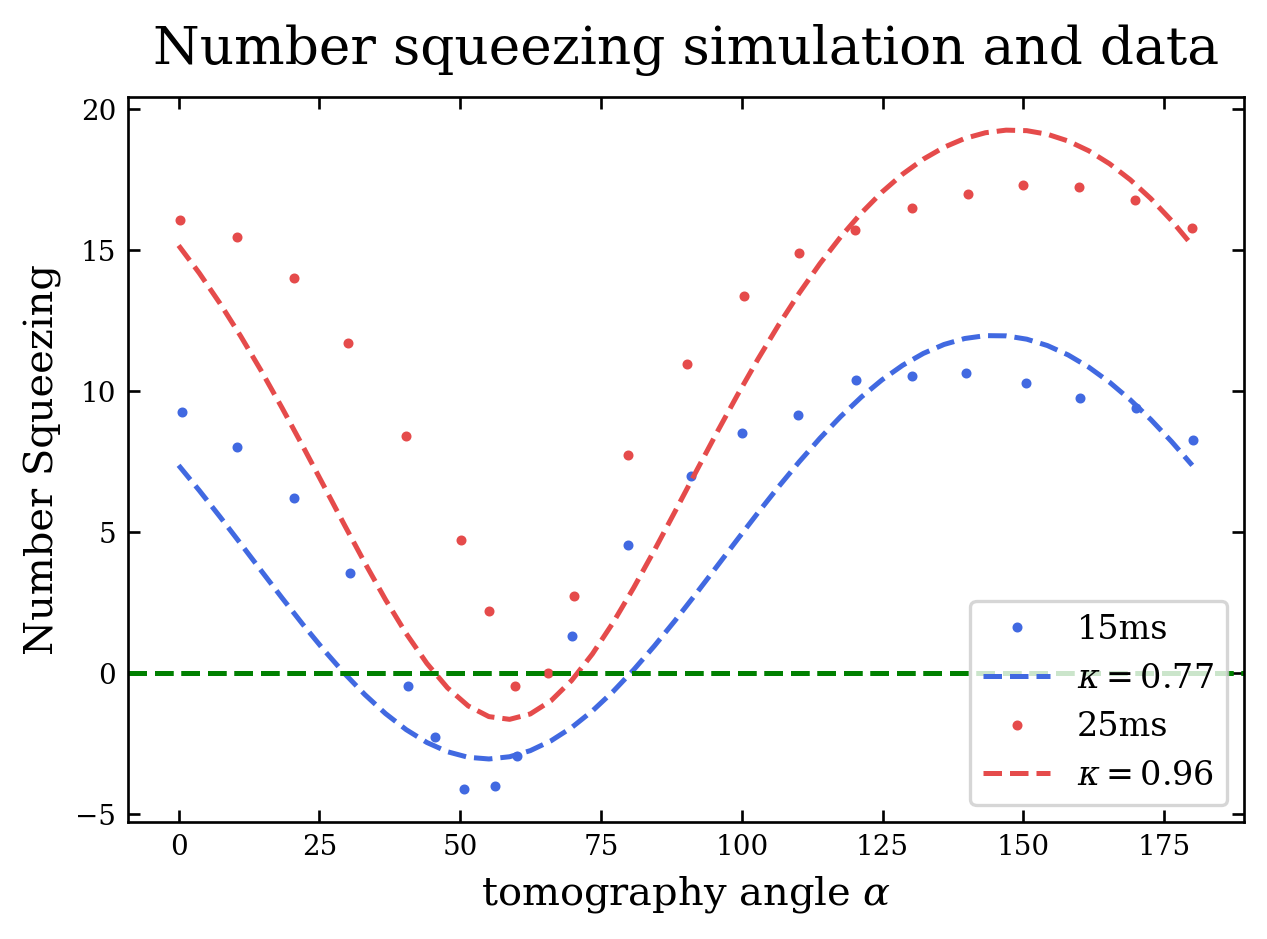

In [112]:
plt.figure(dpi=120)
plt.title("Number squeezing simulation and data", fontsize=16)


Nalphas = 50
alphas = np.linspace(0, np.pi, Nalphas);

varsUp = np.zeros(Nalphas);
varsDown = np.zeros(Nalphas);

#theta_1 = omegax*t1/2
#kappa_1 = chi*t1+0.2

theta_1 = 0.23
kappa_1 = 0.77

theta_2 = omegax*t2/2
kappa_2 = chi*t2+0.02

print(kappa_1)
print(kappa_2)



for ii in np.arange(Nalphas):
    varsUp[ii], varsDown[ii] = Kerr_Ramsey_trotterized(theta_1, kappa_1, alpha=alphas[ii], var=True, fock_number=Nat)

Lz_var = varsUp + varsDown
number_squeezing_1 = number_squeezing_factor_to_db(2.5, Lz_var)*15


# second time
for ii in np.arange(Nalphas):
    varsUp[ii], varsDown[ii] = Kerr_Ramsey_trotterized(theta_2, kappa_2, alpha=alphas[ii], var=True, fock_number=Nat)


Lz_var = varsUp + varsDown
number_squeezing_2 = number_squeezing_factor_to_db(2.5, Lz_var)*5



plt.axhline(y=0, color='g', linestyle='--')
plt.ylabel('Number Squeezing')
plt.xlabel(r'tomography angle $\alpha$')


plt.plot(data_strobel_15.dB, data_strobel_15.alpha, 'o', color='C0', label="15ms", markersize=2)
plt.plot(np.degrees(alphas), number_squeezing_1,  "--", color='C0', markersize=2, label=fr"$\kappa=${kappa_1:.2f}")

plt.plot(data_strobel_25.dB, data_strobel_25.alpha, 'o', label="25ms", markersize=2, color="C1")
plt.plot(np.degrees(alphas), number_squeezing_2, "--",  markersize=2, color="C1", label=fr"$\kappa=${kappa_2:.2f}")

plt.axhline(y=0, color='g', linestyle='--')
plt.legend()

The following is code to evaluate the effects of slight changes of $\kappa$ and $\theta$. To use the code for $\kappa$ set the value of $\theta$ to a fix value and dynamically change the value for $\kappa$ in the for loop. To do this define a range of $\kappa$ to test by declaring a numpy list with 9 values to test. The testing is analogous for $\theta$.

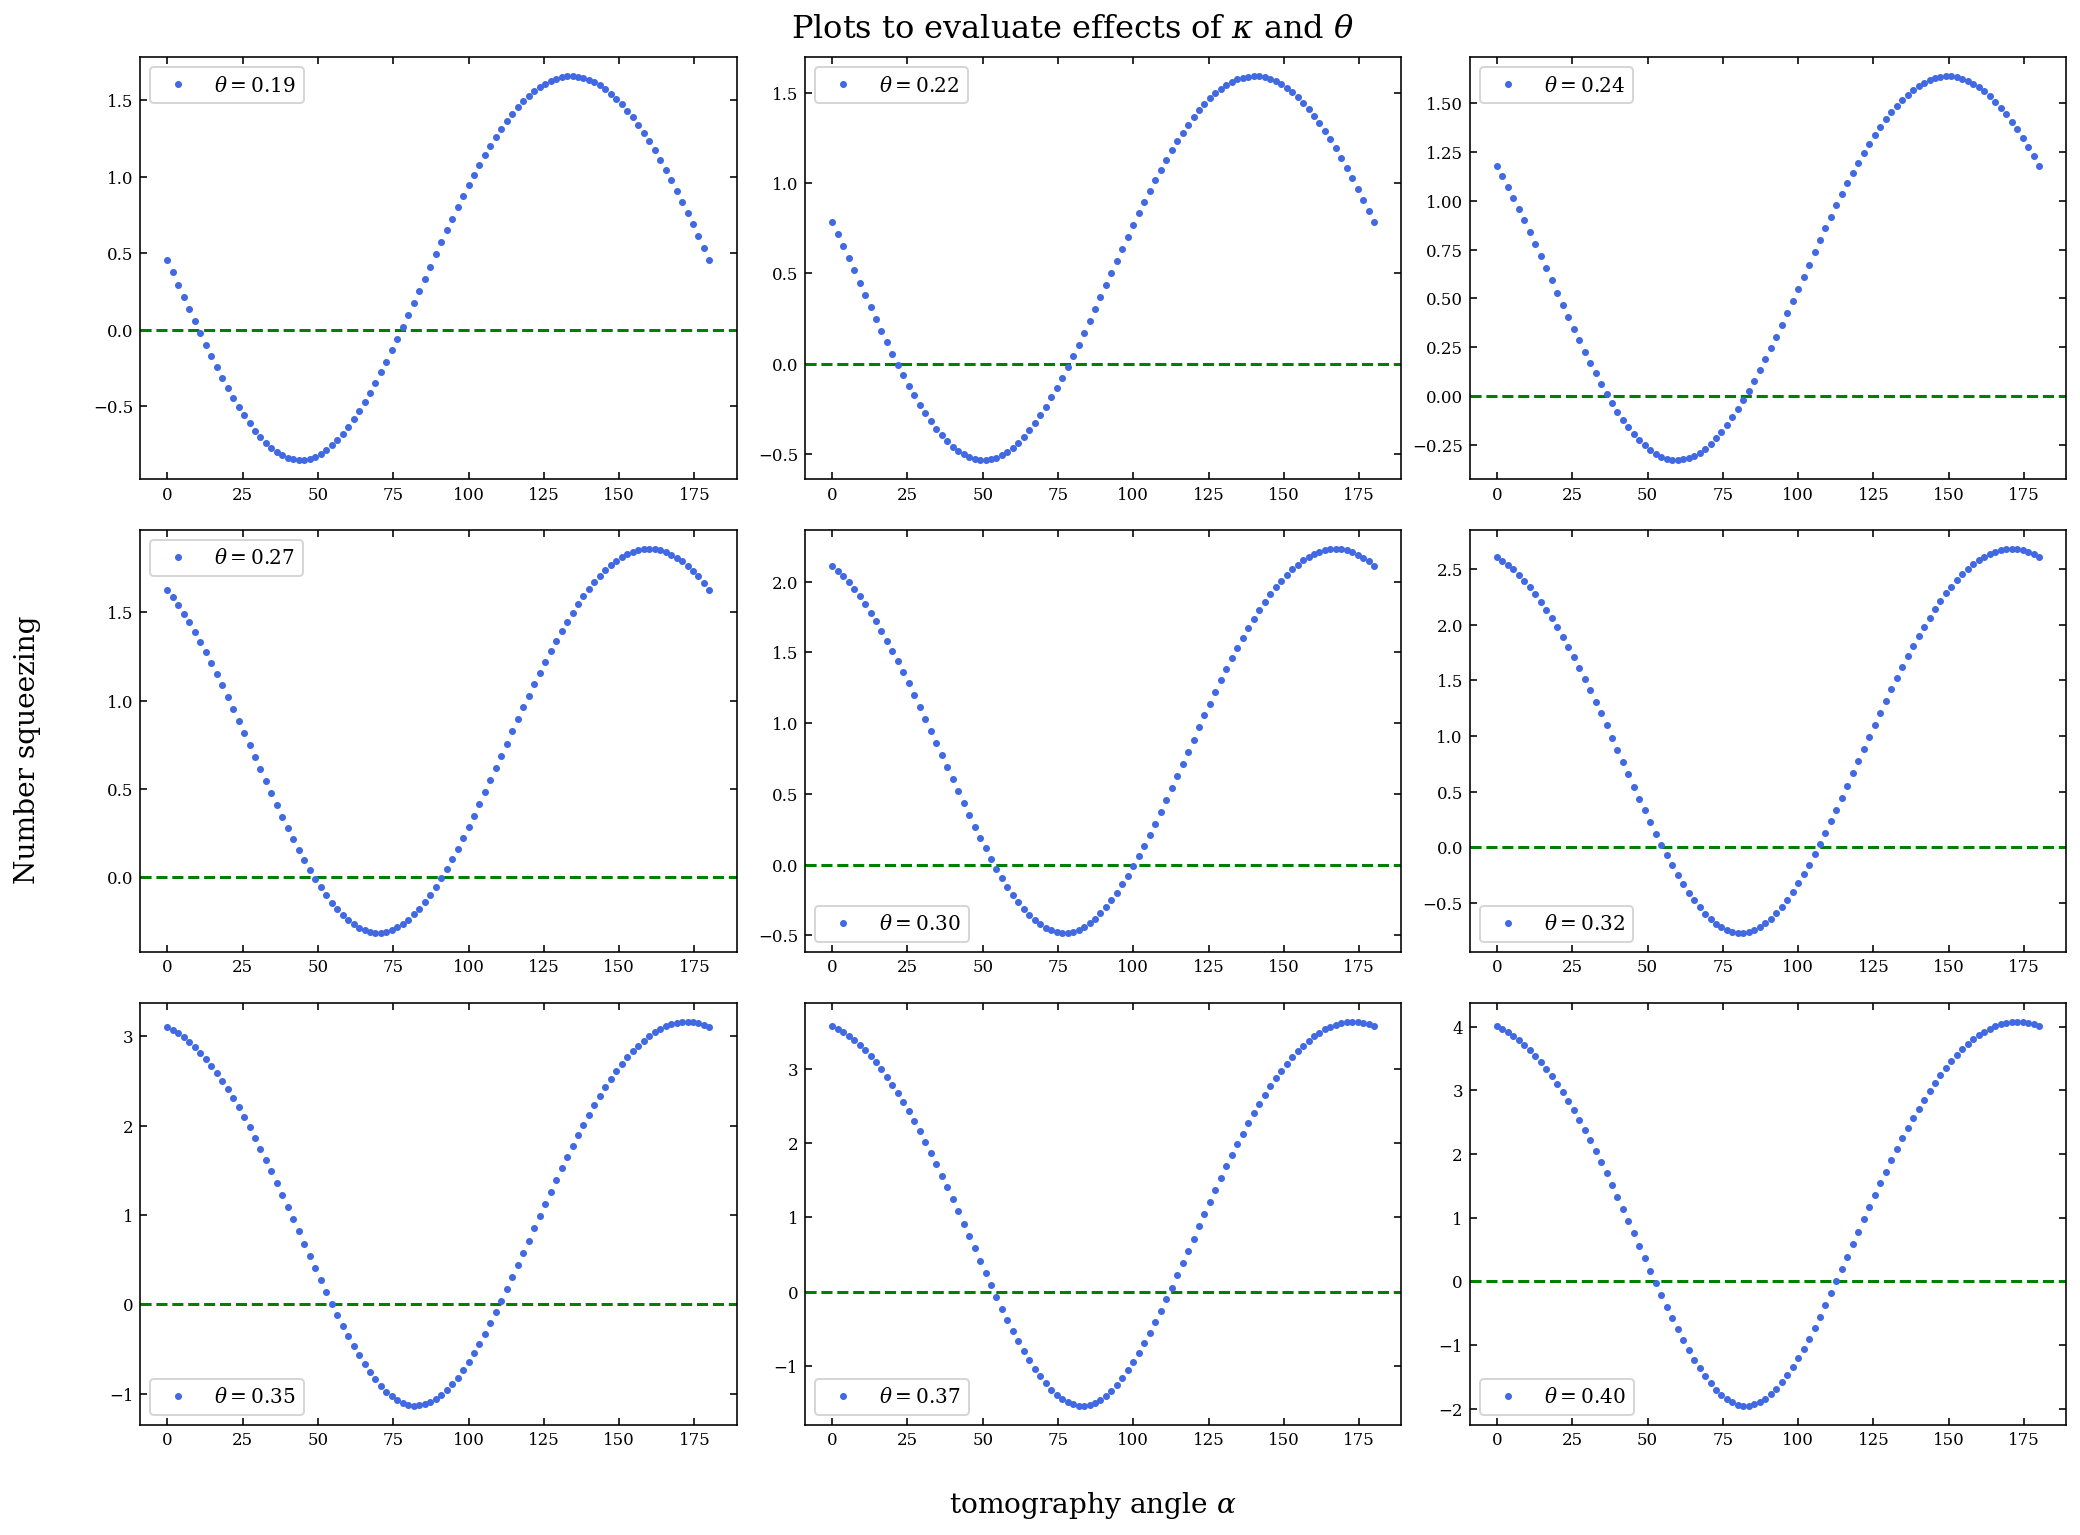

In [120]:
Nalphas = 50
alphas = np.linspace(0, np.pi, Nalphas)

varsUp = np.zeros(Nalphas)
varsDown = np.zeros(Nalphas)


num_rows = 3
num_cols = 3

Nalphas = 100
Nkappas = num_rows*num_cols

thetas = np.linspace(0.19, 0.4, 9)
kappas = np.linspace(0.19, 0.4, 9)
alphas = np.linspace(0, np.pi, Nalphas);
fig, axs = plt.subplots(num_rows, num_cols, figsize=(14,10))
fig.tight_layout()

fig.text(0.5, -0.03, r'tomography angle $\alpha$', ha='center', fontsize=14)
fig.text(-0.035, 0.5, 'Number squeezing', va='center', rotation='vertical', fontsize=14)
fig.text(0.35, 1, r'Plots to evaluate effects of $\kappa$ and $\theta$', va='center', fontsize=16)


for i in range(num_rows):
    for j in range(num_cols):
        index = i*num_cols+j


        varsUp = np.zeros(Nalphas);
        varsDown = np.zeros(Nalphas);


        for ii in np.arange(Nalphas):
            #Change thetas[index] to fix and value and replace the second argument by kappas[index] to test different kappas
            varsUp[ii], varsDown[ii] = Kerr_Ramsey_trotterized(thetas[index], 0.77, alpha=alphas[ii], var=True, fock_number=Nat)

        Lz_var = varsUp + varsDown
        number_squeezing_1 = number_squeezing_factor_to_db(2.5, Lz_var)*2


        axs[i, j].axhline(y=0, color='g', linestyle='--')

        axs[i, j].plot(np.degrees(alphas), number_squeezing_1, ".", label=fr"$\theta=${thetas[index]:.2f}", markersize=5)
        axs[i, j].legend()